# PyTorch Lightning

In [1]:
%load_ext watermark
%watermark -a 'NavinKumarMNK' -v -p torch,lightning

Author: NavinKumarMNK

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.12.0

torch    : 2.0.0
lightning: 2.0.1.post0



In [2]:
import os
import torch
import lightning.pytorch as pl

from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

import matplotlib.pyplot as plt
import numpy as np


## Encoder-Decoder Model

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),    
        )
        self.fc = nn.Linear(64, 64)
        self.bn = nn.BatchNorm1d(64)
        

    def forward(self, x: torch.Tensor):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.bn(x)
        return x
    
model = Encoder()
x = torch.rand((16, 1, 28, 28))
y = model(x)
print(y, y.shape)

tensor([[ 0.2279,  0.1954, -0.0841,  ...,  0.1867,  0.1614,  0.1694],
        [ 0.3154,  0.1605, -0.2420,  ...,  0.4184,  0.4320,  0.0933],
        [ 0.4130,  0.2342, -0.0046,  ...,  0.1078,  0.0769,  0.1416],
        ...,
        [ 0.3281,  0.2172,  0.1280,  ...,  0.1567,  0.3522,  0.2101],
        [-0.2692,  0.0963, -0.4815,  ..., -0.0081, -0.0325, -0.3490],
        [ 0.0965, -0.0871, -0.1300,  ..., -0.0109,  0.1700,  0.0357]],
       grad_fn=<NativeBatchNormBackward0>) torch.Size([16, 64])


In [4]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(64, 16*64),
            nn.Unflatten(dim=1, unflattened_size=(64, 4, 4)),
            nn.ReLU(),  
            nn.ConvTranspose2d(64, 16, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Tanh()
        )
    
    def forward(self, x: torch.Tensor):
        x = self.model(x)
        return x
    
model = Decoder()
x = torch.rand((16, 64))
y = model(x)
print(y, y.shape)

tensor([[[[0.0587, 0.0000, 0.3608,  ..., 0.0000, 0.2260, 0.0000],
          [0.0000, 0.1727, 0.1478,  ..., 0.0000, 0.0720, 0.0680],
          [0.0000, 0.0000, 0.0000,  ..., 0.2874, 0.3230, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0154,  ..., 0.5328, 0.2041, 0.0285],
          [0.0000, 0.0000, 0.0512,  ..., 0.4591, 0.2697, 0.0000],
          [0.0000, 0.0000, 0.0199,  ..., 0.0016, 0.0000, 0.0097]]],


        [[[0.0420, 0.0000, 0.2548,  ..., 0.0000, 0.1973, 0.0000],
          [0.0000, 0.0000, 0.1701,  ..., 0.1271, 0.0000, 0.1126],
          [0.0000, 0.0000, 0.2483,  ..., 0.2217, 0.2721, 0.0000],
          ...,
          [0.0000, 0.0157, 0.1356,  ..., 0.7515, 0.3468, 0.0000],
          [0.0054, 0.1022, 0.1290,  ..., 0.3242, 0.1013, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0855]]],


        [[[0.0235, 0.0000, 0.2285,  ..., 0.0000, 0.1676, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1287],
          [0.0000, 0.0000, 0.0535,  ..

### PyTorch Lightning Module

In [5]:
class AutoEncoder(pl.LightningModule):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
            
    def training_step(self, batch, batch_idx):
        x, _ = batch
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer        
    

In [6]:
dataset = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor())
train_loader = DataLoader(dataset, batch_size=32)

<pre>
autoencoder = AutoEncoder()
optimizer = autoencoder.configure_optimizers()

for batch_idx, batch in enumerate(train_loader):
    loss = autoencoder.training_step(batch, batch_idx)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
</pre>

In [9]:
autoencoder = AutoEncoder()
trainer = pl.Trainer(max_epochs=1, min_epochs=1)
trainer.fit(model=autoencoder, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 23.1 K
1 | decoder | Decoder | 94.4 K
------------------------------------
117 K     Trainable params
0         Non-trainable params
117 K     Total params
0.470     Total estimated model params size (MB)
/home/mnk/python3/envs/pytorch2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


### Validataion & Predict Step 

In [10]:
torch.save(autoencoder.state_dict(), "./state_dict.pth")
!ls

lightning_logs	MNIST  state_dict.pth  Untitled.ipynb


In [11]:
def validation_step(self, batch, batch_idx):
    x, _ = batch
    z = self.encoder(x)
    x_hat = self.decoder(z)
    loss = F.mse_loss(x_hat, x)
    self.log("val_loss", loss, prog_bar=True)
    return loss
    
AutoEncoder.validation_step = validation_step

In [12]:
def predict(self, x):
    self.eval()
    with torch.no_grad():
        z = self.encoder(x)
        x_hat = self.decoder(z)
    return x_hat

AutoEncoder.predict = predict

In [15]:
%%time 
autoencoder.predict(dataset[0][0].unsqueeze(0))

CPU times: user 9.57 ms, sys: 515 µs, total: 10.1 ms
Wall time: 15.3 ms


tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 4.1125e-02, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2160e-03, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

### Early Stopping and Checkpointing

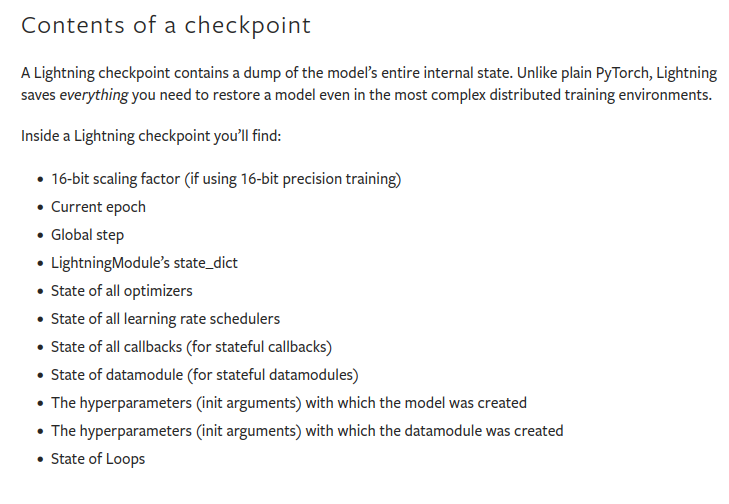

In [16]:
class MyEarlyStopping(EarlyStopping):
    def on_train_end(self, trainer, pl_module):
        self._run_early_stopping_check(trainer)

callbacks = []
#callbacks.append(MyEarlyStopping(monitor="val_loss", mode="min"))

In [45]:
trainer = pl.Trainer(default_root_dir="./",
                     max_epochs=1, 
                     min_epochs=1,
                     callbacks=callbacks,
                     profiler="simple"
                )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [24]:
dataset = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor())

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_indices, val_indices = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_indices, batch_size = 16)
val_loader = DataLoader(val_indices, batch_size = 16)

trainer.fit(model=autoencoder, train_dataloaders=train_loader, val_dataloaders=val_loader)

Missing logger folder: checkpoint.cpkt/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 23.1 K
1 | decoder | Decoder | 94.4 K
------------------------------------
117 K     Trainable params
0         Non-trainable params
117 K     Total params
0.470     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [28]:
# Resume
trainer.fit(model=autoencoder, train_dataloaders=train_loader, val_dataloaders=val_loader, ckpt_path="/home/mnk/MegNav/Projects/NavinKumarMNK/PyTorch/PyTorchLightning/lightning_logs/version_19/checkpoints/epoch=0-step=3000.ckpt")

Restoring states from the checkpoint path at /home/mnk/MegNav/Projects/NavinKumarMNK/PyTorch/PyTorchLightning/lightning_logs/version_19/checkpoints/epoch=0-step=3000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 23.1 K
1 | decoder | Decoder | 94.4 K
------------------------------------
117 K     Trainable params
0         Non-trainable params
117 K     Total params
0.470     Total estimated model params size (MB)
Restored all states from the checkpoint at /home/mnk/MegNav/Projects/NavinKumarMNK/PyTorch/PyTorchLightning/lightning_logs/version_19/checkpoints/epoch=0-step=3000.ckpt


Sanity Checking: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


### Visualization

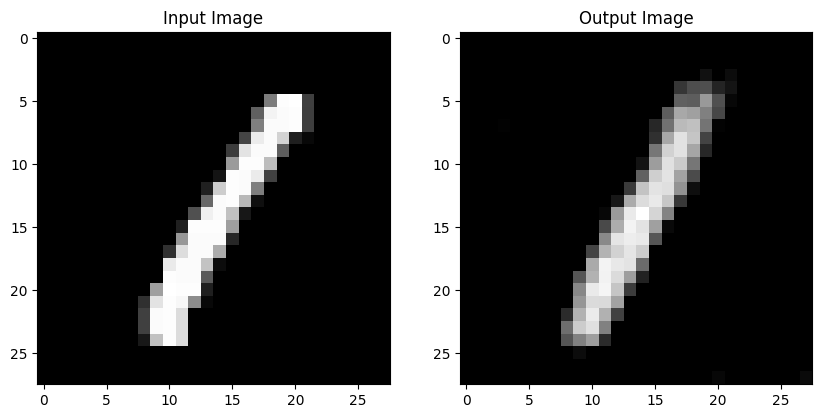

In [43]:
inp = dataset[3][0].unsqueeze(0)
output = autoencoder.predict(inp)

np1 = inp.numpy()
np2 = (output * 0.5 + 0.5) * 255  # Convert back to grayscale values
np2 = np2.reshape(28, 28)  # Reshape to original dimensions

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np1.squeeze(0).squeeze(0), cmap="gray")
axes[0].set_title('Input Image')
axes[1].imshow(np2, cmap="gray")
axes[1].set_title('Output Image')
plt.show()

### Debug
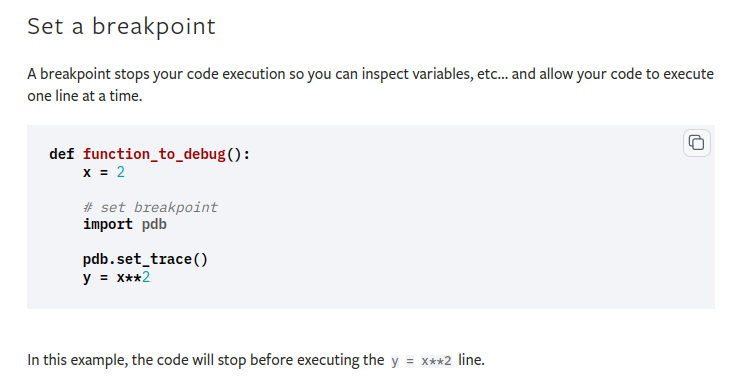
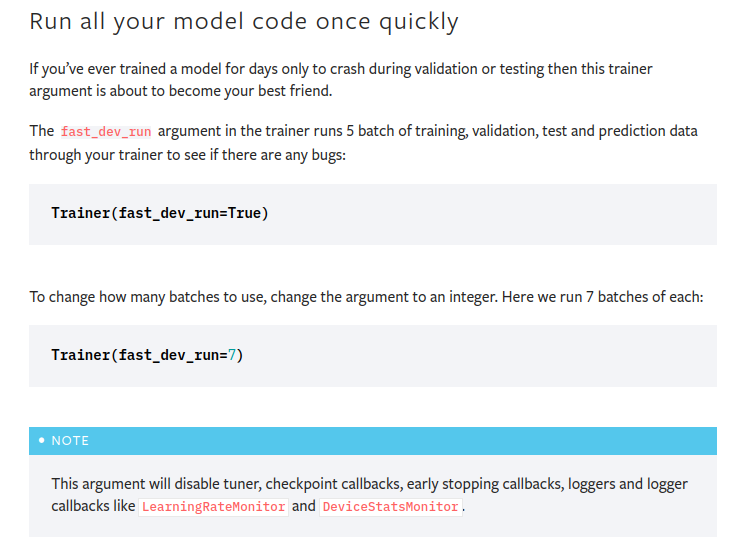
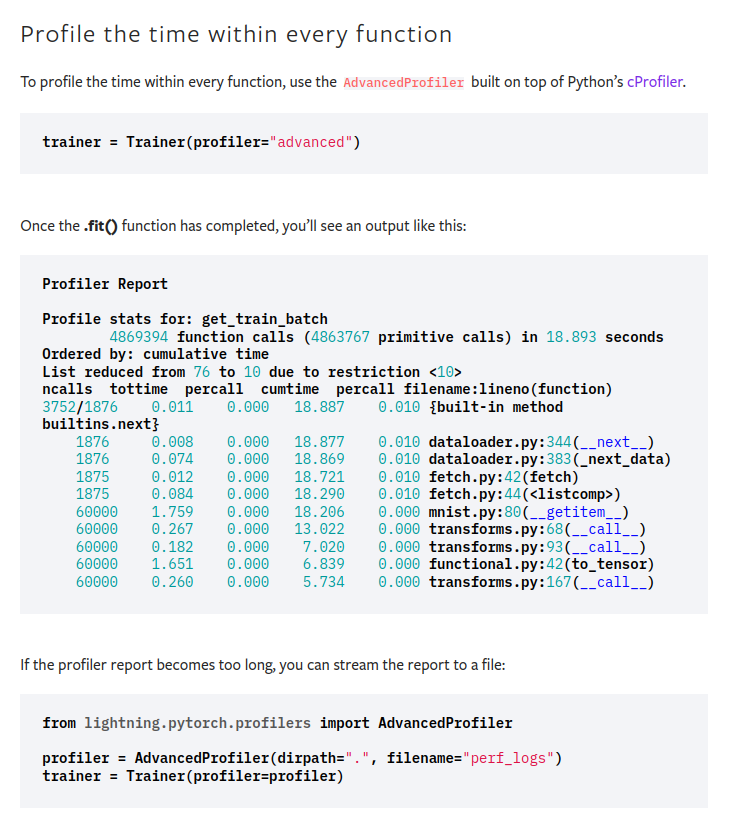
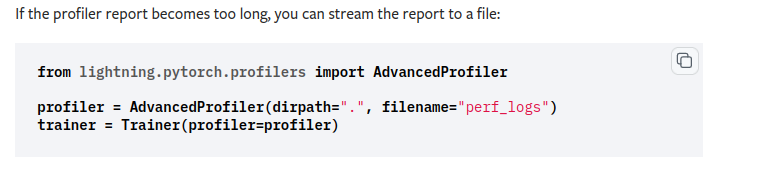

### PreTrain Models
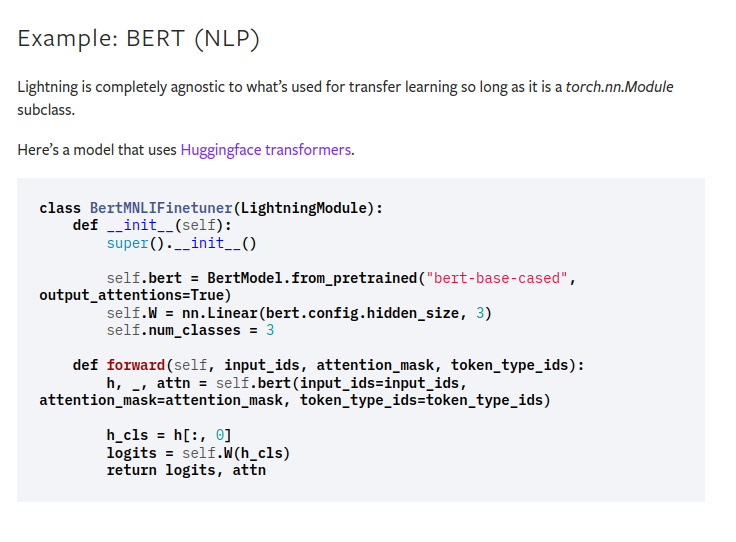